##This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting  the sales quantity of various products 
##across different stores. 
##We're going to take the following approach:

1.Problem definition

2.Data

3.Evaluation

4.Features

5.Modelling

6.Experimentation



##PROBLEM STATEMENT

In this project, your primary task is to analyze a large-scale retail dataset and develop 
robust predictive models capable of forecasting the sales quantity of various products 
across different stores.

In [34]:
#importing all the necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##scikit learn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [2]:
#Reading the dataset using pandas
df= pd.read_csv("train.csv")
df.head()


,date,day_of_week,month,quarter,is_weekend,is_holiday,store_id,region,store_type,city,...,stock_level,stock_out,temperature_celsius,economic_index,inflation_rate,sales_quantity,price_weight_ratio,revenue,customer_value_score,seasonal_score
0,2022-01-01,Saturday,1,1,1,0,ST_0046,East,Standalone,Jaipur,...,182,0,20.7,80.0,9.5,29.0,34.381579,1515.54,19.20780,0.8
1,2022-01-01,Saturday,1,1,1,0,ST_0303,East,Airport,Pune,...,357,0,16.3,103.7,4.5,16.0,134.527301,13797.12,70.49556,0.8
2,2022-01-01,Saturday,1,1,1,0,ST_0129,Central,Mall,Mumbai,...,346,0,22.6,NaN,10.1,7.0,20087.727273,46402.65,36.63408,0.8
3,2022-01-01,Saturday,1,1,1,0,ST_0297,North,Standalone,Jaipur,...,43,0,17.0,122.4,7.8,11.0,1585.480000,4360.07,46.96324,0.8
4,2022-01-01,Saturday,1,1,1,0,ST_0194,North,Airport,Ahmedabad,...,37,0,NaN,NaN,5.0,8.0,620.364706,4218.48,12.14316,0.8


In [3]:
#shape of the dataframe(rows, columns)
df.shape

(900000, 44)

In [4]:
#looking for missing values
df.isnull().sum().sort_values(ascending=False)


economic_index          107803
customer_value_score     90767
temperature_celsius      72036
store_rating             54120
competition_distance     54026
marketing_spend          54015
price_weight_ratio       53880
weight_kg                53880
customer_age             46585
customer_income          46584
date                         0
day_of_week                  0
establishment_year           0
store_size_sqft              0
city                         0
store_type                   0
region                       0
store_id                     0
is_holiday                   0
is_weekend                   0
quarter                      0
month                        0
subcategory                  0
category                     0
staff_count                  0
product_id                   0
parking_available            0
competitor_count             0
warranty_months              0
returnable                   0
brand_tier                   0
launch_year                  0
actual_p

In [35]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.isocalendar().week
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear


In [36]:
#median imputation for stable replacement without skewing distributions.

num_cols_with_na = [
    'economic_index', 'customer_value_score', 'temperature_celsius',
    'store_rating', 'competition_distance', 'marketing_spend',
    'weight_kg', 'price_weight_ratio', 'customer_age', 'customer_income'
]

for col in num_cols_with_na:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)   #No inplace, no warning


#WHY I CHOSE MEDIAN OVER MEAN
#✅ Robust against outliers
#✅ Safe for production pipeline consistency

In [7]:
print(df.isnull().sum().sort_values(ascending=False))


date                    0
day_of_week             0
month                   0
quarter                 0
is_weekend              0
is_holiday              0
store_id                0
region                  0
store_type              0
city                    0
store_size_sqft         0
establishment_year      0
parking_available       0
competition_distance    0
competitor_count        0
store_rating            0
staff_count             0
product_id              0
category                0
subcategory             0
base_price              0
actual_price            0
brand_tier              0
launch_year             0
weight_kg               0
returnable              0
warranty_months         0
customer_age            0
customer_income         0
customer_gender         0
discount_percent        0
promotion_active        0
marketing_spend         0
customer_footfall       0
stock_level             0
stock_out               0
temperature_celsius     0
economic_index          0
inflation_ra

In [8]:
df.describe()

,date,month,quarter,is_weekend,is_holiday,store_size_sqft,establishment_year,parking_available,competition_distance,competitor_count,...,inflation_rate,sales_quantity,price_weight_ratio,revenue,customer_value_score,seasonal_score,day,weekofyear,year,dayofyear
count,900000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,9.000000e+05,900000.000000,900000.000000,900000.000000,900000.0,900000.000000,900000.000000
mean,2022-12-08 00:24:25.824000,6.175001,2.408377,0.286150,0.030032,7899.042949,2016.163131,0.697081,2114.342585,3.000213,...,6.000687,7.589154,9183.372168,2.298147e+04,28.720970,1.094211,15.540558,25.029409,2022.465471,172.120010
min,2022-01-01 00:00:00,1.000000,1.000000,0.000000,0.000000,1001.000000,2010.000000,0.000000,-2058.880000,0.000000,...,-3.600000,0.000000,3.232558,0.000000e+00,1.824840,0.800000,1.000000,1.0,2022.000000,1.000000
25%,2022-06-20 00:00:00,3.000000,1.000000,0.000000,0.000000,4097.000000,2013.000000,0.000000,710.627500,2.000000,...,4.700000,1.000000,516.022457,9.922200e+02,17.178840,0.900000,8.000000,13.0,2022.000000,86.000000
50%,2022-12-08 00:00:00,6.000000,2.000000,0.000000,0.000000,8035.000000,2016.000000,1.000000,1530.070000,3.000000,...,6.000000,4.000000,1892.945946,5.833030e+03,24.631020,1.000000,15.000000,25.0,2022.000000,171.000000
75%,2023-05-28 00:00:00,9.000000,3.000000,1.000000,0.000000,11640.000000,2020.000000,1.000000,2742.670000,4.000000,...,7.400000,9.000000,6809.007092,1.710066e+04,35.028000,1.300000,23.000000,37.0,2023.000000,257.000000
max,2023-11-16 00:00:00,12.000000,4.000000,1.000000,1.000000,14971.000000,2022.000000,1.000000,18333.280000,15.000000,...,15.400000,1585.427558,302978.333333,1.757626e+07,359.412300,1.600000,31.000000,52.0,2023.000000,365.000000
std,NaN,3.285599,1.083202,0.451961,0.170676,4124.134962,3.758154,0.459521,2240.723700,1.732902,...,2.003797,13.183912,24287.484002,1.046613e+05,17.796858,0.259107,8.794288,14.323212,0.498807,100.174935


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  900000 non-null  datetime64[ns]
 1   day_of_week           900000 non-null  object        
 2   month                 900000 non-null  int64         
 3   quarter               900000 non-null  int64         
 4   is_weekend            900000 non-null  int64         
 5   is_holiday            900000 non-null  int64         
 6   store_id              900000 non-null  object        
 7   region                900000 non-null  object        
 8   store_type            900000 non-null  object        
 9   city                  900000 non-null  object        
 10  store_size_sqft       900000 non-null  int64         
 11  establishment_year    900000 non-null  int64         
 12  parking_available     900000 non-null  int64         
 13 

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np

# Set seaborn theme
sns.set_theme(style="whitegrid")

In [11]:
!pip install pandas-profiling
!pip install plotly

  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached MarkupSafe-2.1.5.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [19 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
      exec(compile('''
      ~~~~^^^^^^^^^^^^
      # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ...<31 lines>...
      exec(compile(setup_py_code, filename, "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ''' % ('C:\\Users\\Aadya\\AppData\\Local\\Temp\\pip-install-ycbyg7r7\\htmlmin_4a49b964147e4bf0936547529aeedc27\\setup.py',), "<pip-setuptools-caller>", "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Aadya\AppData\Local\Temp\pip-install-y

In [12]:
import sys
print(sys.version)


3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]


In [13]:
!pip install ydata-profiling

ERROR: Could not find a version that satisfies the requirement ydata-profiling (from versions: none)
ERROR: No matching distribution found for ydata-profiling


In [38]:
import plotly
print(plotly.__version__)


6.0.1


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style="whitegrid")




Heatmap:

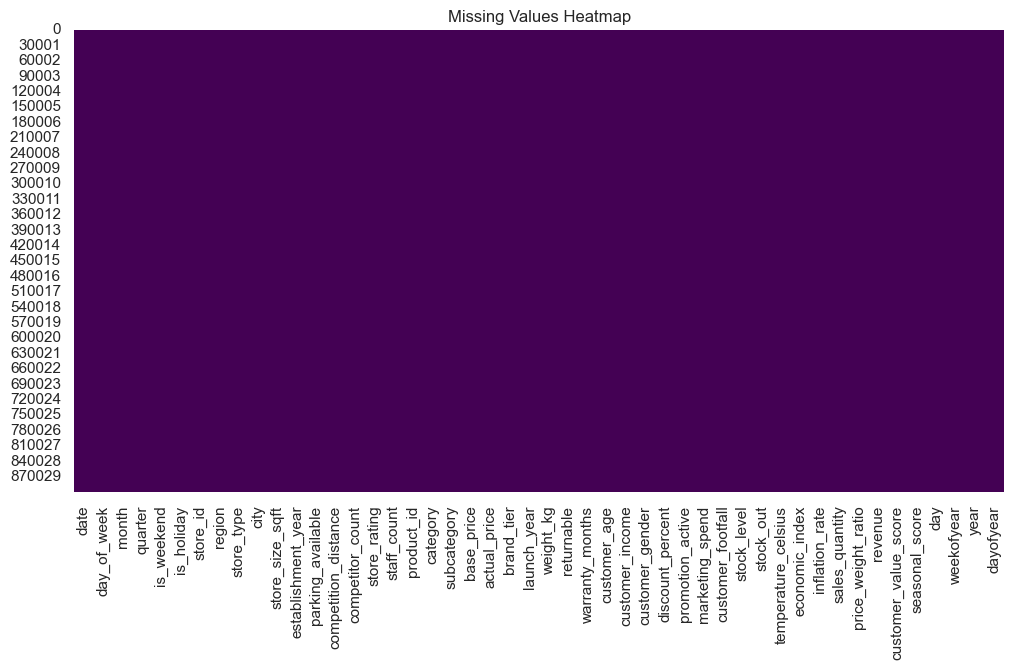

In [16]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


In [17]:
print(df.isnull().sum().sort_values(ascending=False).head(10))


date           0
day_of_week    0
month          0
quarter        0
is_weekend     0
is_holiday     0
store_id       0
region         0
store_type     0
city           0
dtype: int64


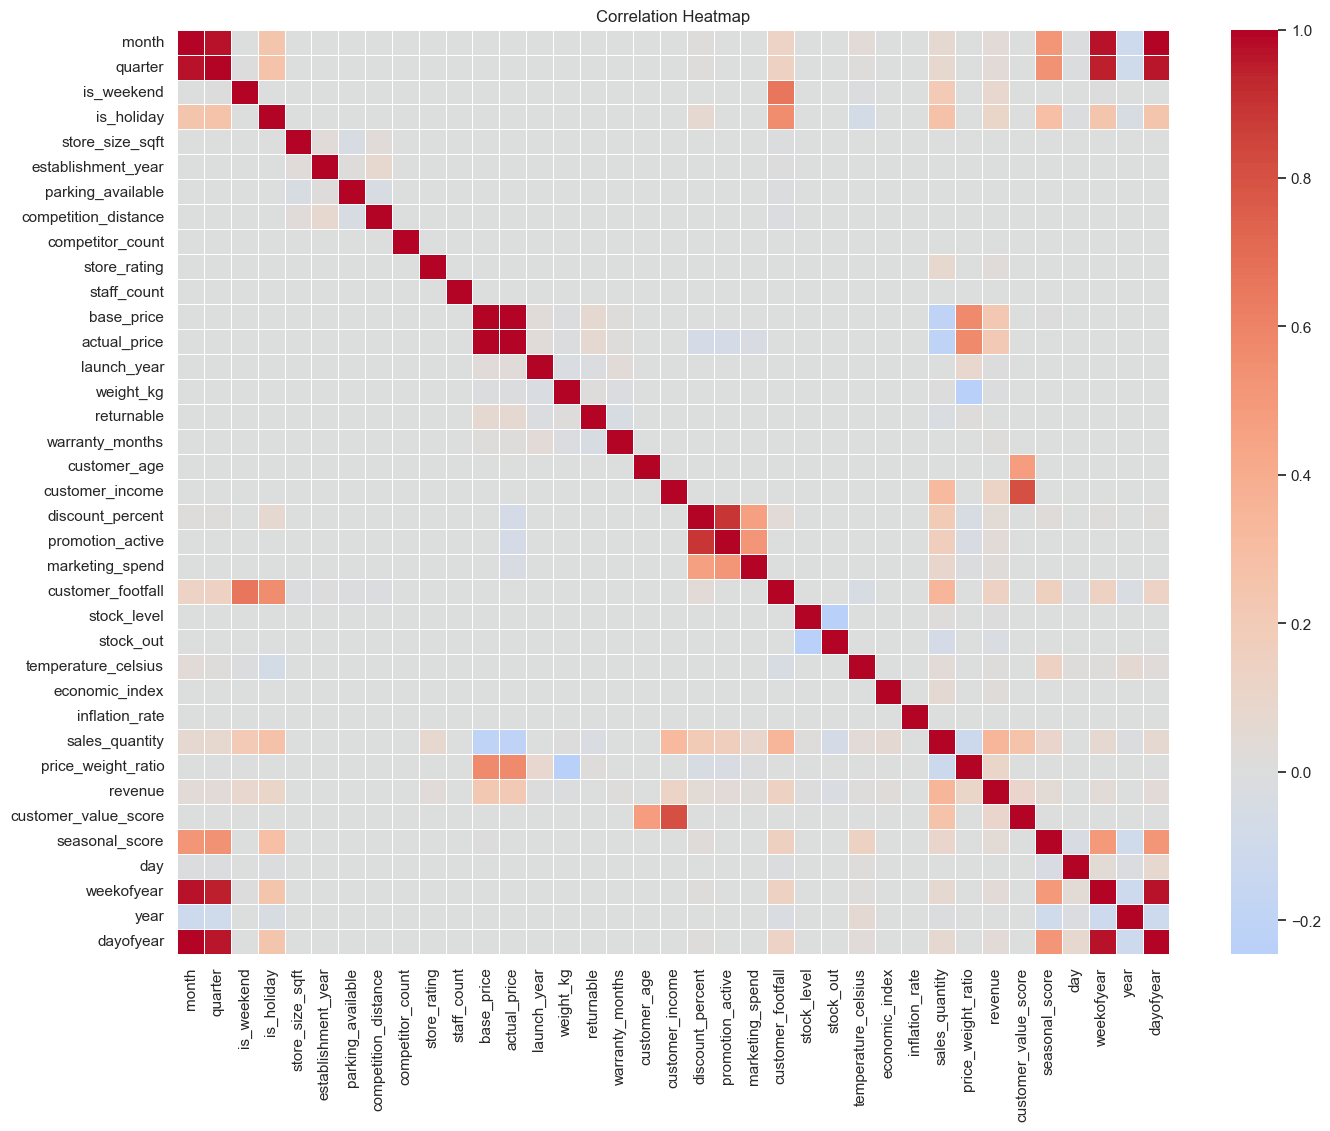

In [18]:
plt.figure(figsize=(16,12))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

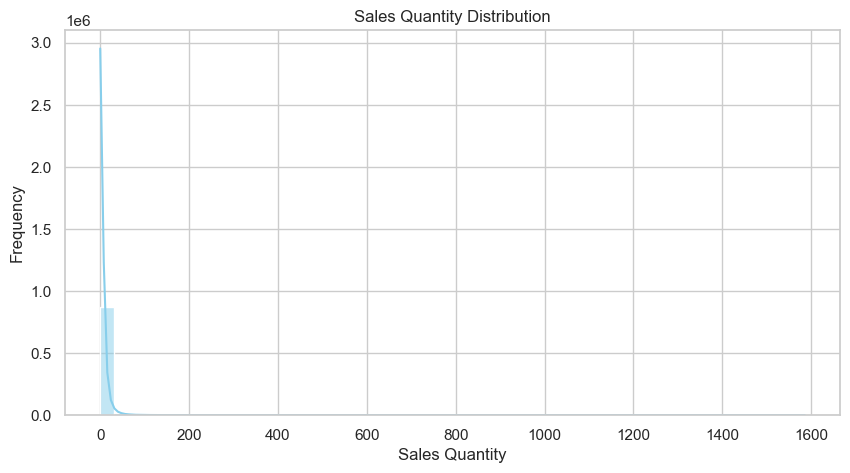

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(df['sales_quantity'], bins=50, kde=True, color='skyblue')
plt.title("Sales Quantity Distribution")
plt.xlabel("Sales Quantity")
plt.ylabel("Frequency")
plt.show()

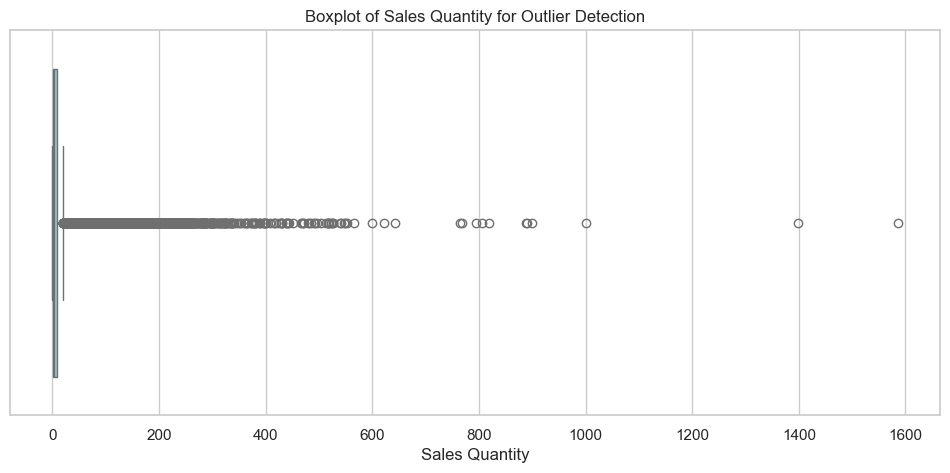

In [20]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df['sales_quantity'], color='skyblue')
plt.title("Boxplot of Sales Quantity for Outlier Detection")
plt.xlabel("Sales Quantity")
plt.show()


C:\Users\Aadya\AppData\Local\Temp\ipykernel_9340\1812327196.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='region', y='sales_quantity', data=df, estimator=np.mean, ci='sd', palette='pastel')
C:\Users\Aadya\AppData\Local\Temp\ipykernel_9340\1812327196.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region', y='sales_quantity', data=df, estimator=np.mean, ci='sd', palette='pastel')


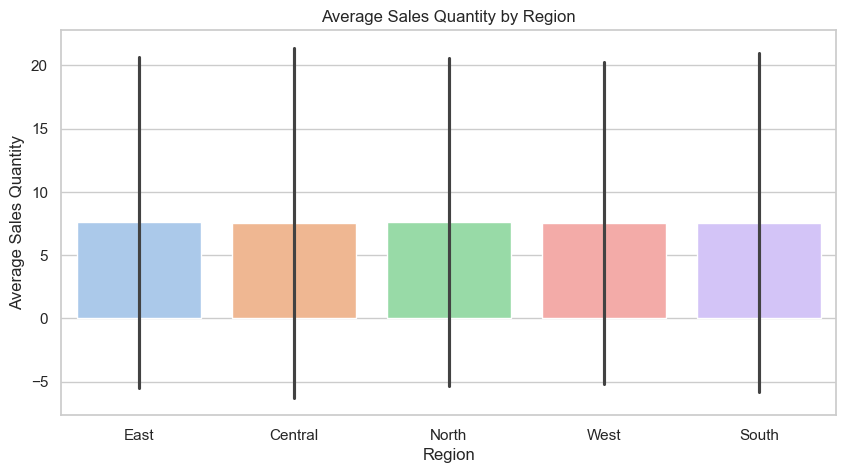

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='region', y='sales_quantity', data=df, estimator=np.mean, ci='sd', palette='pastel')
plt.title("Average Sales Quantity by Region")
plt.xlabel("Region")
plt.ylabel("Average Sales Quantity")
plt.show()


“The average sales quantity across all regions is nearly uniform (5–10 units), indicating that region alone does not strongly differentiate sales performance in this dataset. We may need to explore combinations of region with other factors like store type, promotions, or seasonality for deeper patterns.”

C:\Users\Aadya\AppData\Local\Temp\ipykernel_9340\2311360185.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='store_type', y='sales_quantity', data=df, estimator=np.mean, ci='sd', palette='muted')
C:\Users\Aadya\AppData\Local\Temp\ipykernel_9340\2311360185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='store_type', y='sales_quantity', data=df, estimator=np.mean, ci='sd', palette='muted')


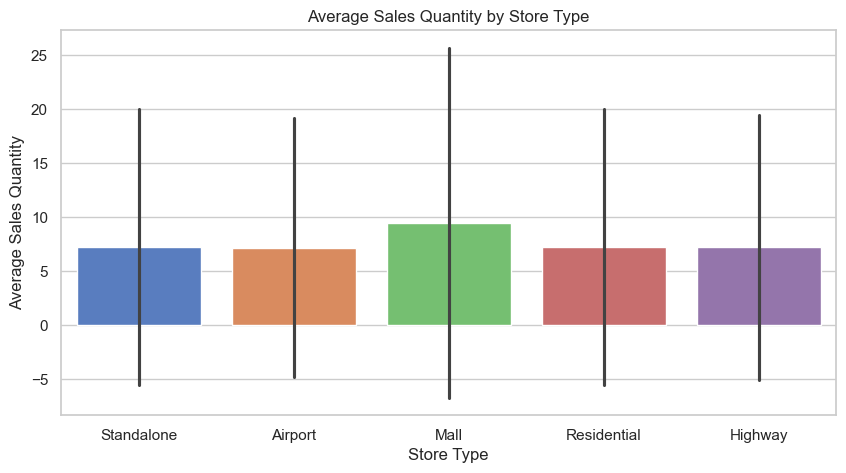

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales_quantity', data=df, estimator=np.mean, ci='sd', palette='muted')
plt.title("Average Sales Quantity by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Average Sales Quantity")
plt.show()

“Mall store types exhibit slightly higher average sales quantities compared to standalone, airport, residential, and highway stores, suggesting that store type can have a moderate impact on sales performance.”

C:\Users\Aadya\AppData\Local\Temp\ipykernel_9340\523566183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='promotion_active', y='sales_quantity', data=df, palette='Set2')


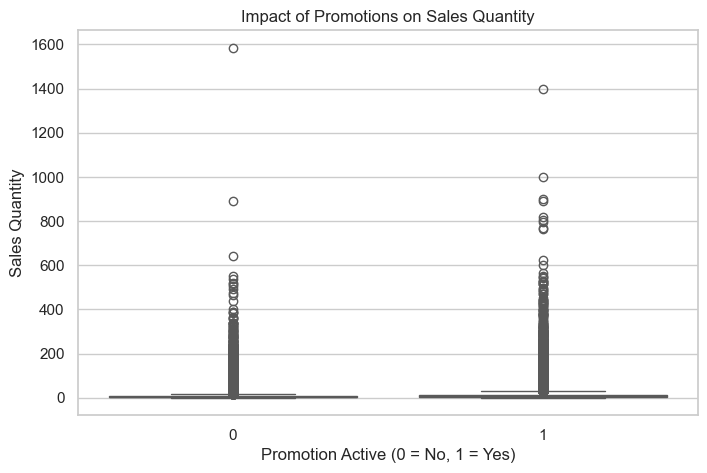

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x='promotion_active', y='sales_quantity', data=df, palette='Set2')
plt.title("Impact of Promotions on Sales Quantity")
plt.xlabel("Promotion Active (0 = No, 1 = Yes)")
plt.ylabel("Sales Quantity")
plt.show()


“Promotions lead to a slight increase in sales quantity spread, with more high-quantity outliers, indicating occasional spikes during promotions. However, the median sales quantity remains similar, suggesting that while promotions may trigger high sales events, they do not significantly shift typical sales quantities.”



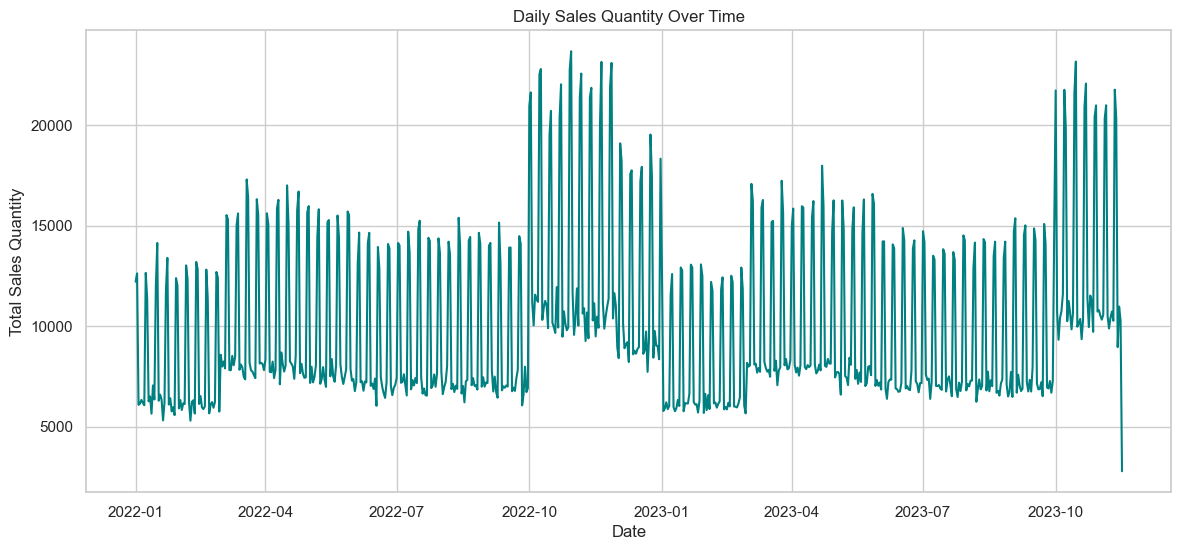

In [40]:
# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Aggregate daily total sales
daily_sales = df.groupby('date')['sales_quantity'].sum().reset_index()

# Plot the time series
plt.figure(figsize=(14,6))
plt.plot(daily_sales['date'], daily_sales['sales_quantity'], color='teal')
plt.title("Daily Sales Quantity Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales Quantity")
plt.show()


"The sales quantity exhibits clear weekly seasonality with noticeable spikes at certain periods, likely due to promotions or seasonal demand. This highlights the importance of including temporal features (day, weekofyear, month) in modeling to capture these cyclical patterns."

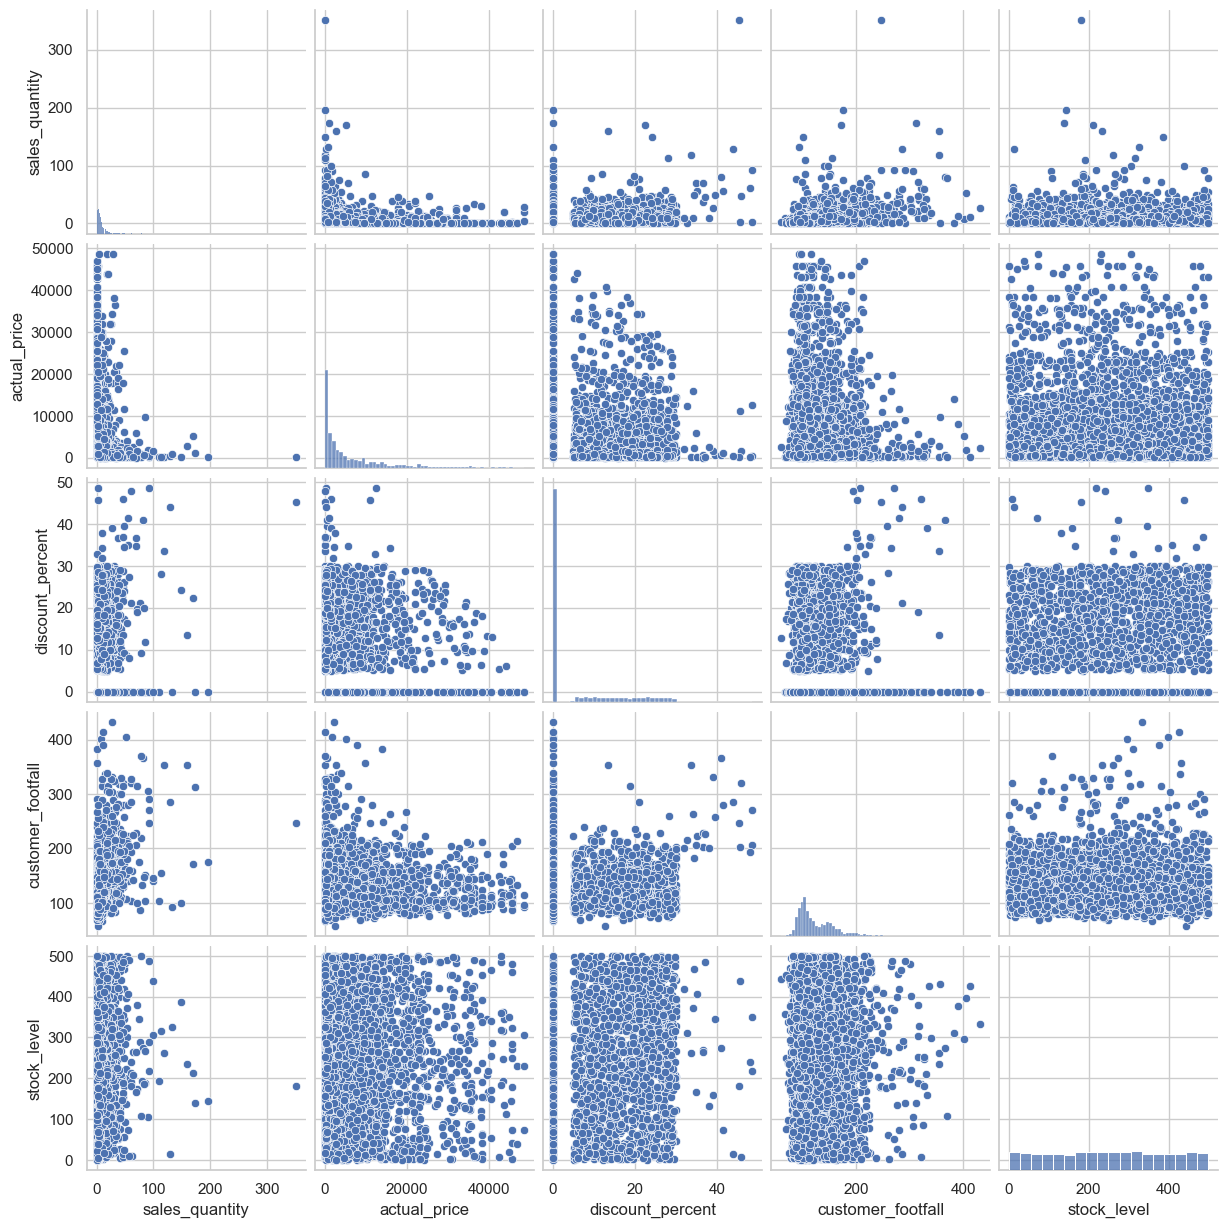

In [25]:
import seaborn as sns

sample_df = df.sample(5000, random_state=42)

sns.pairplot(sample_df[[
    'sales_quantity',
    'actual_price',
    'discount_percent',
    'customer_footfall',
    'stock_level'
]])
plt.show()


##1️⃣ Diagonal: Histograms
These show the distribution of each variable:

_sales_quantity_: Heavily right-skewed (most values low, few high outliers).

_actual_price:_ Right-skewed, many products with low price, few very high-priced.

_discount_percent_: Concentrated at 0, with some values up to 50%.

_customer_footfall_: Slightly right-skewed, most values are low.

_stock_level_: Concentrated in a few bands (discrete levels)

⚡ *Key Takeaways*:
✅ Price impacts sales: Higher prices reduce sales, but many low-price, low-sale instances exist.
✅ Discounts may boost sales but the effect is not strongly linear due to many zero discounts.
✅ Footfall has a mild positive correlation with sales.
✅ No strong linear relationship with stock_level observed, but stock caps may influence availability.

**“The pairplot reveals the heavily skewed nature of sales quantity and actual prices in the dataset. A mild negative correlation is observed between actual price and sales quantity, and between discount percent and actual price. Customer footfall shows a mild positive association with sales quantity, indicating higher customer visits may drive sales. However, most relationships are non-linear and noisy, indicating the need for tree-based models and feature engineering for effective pattern capture.”**

In [41]:
# Price difference between base price and actual price
df['price_diff'] = df['base_price'] - df['actual_price']

# Discount ratio
df['discount_ratio'] = df['discount_percent'] / 100

# Footfall per staff (avoid division by zero)
df['footfall_per_staff'] = df['customer_footfall'] / (df['staff_count'] + 1e-5)

# Promotion interaction feature
df['promotion_discount'] = df['promotion_active'] * df['discount_percent']

# Recompute price_weight_ratio for safety and consistency
df['price_weight_ratio'] = df['actual_price'] / (df['weight_kg'] + 1e-5)

# Log transformation of sales_quantity for stable target if needed later
df['sales_quantity_log'] = np.log1p(df['sales_quantity'])

# (Optional) High discount flag
df['high_discount'] = (df['discount_percent'] > 20).astype(int)

# (Optional) Weekend footfall interaction
df['weekend_footfall'] = df['is_weekend'] * df['customer_footfall']

print("Feature engineering completed. New columns added:")
print(df.columns[-8:])


Feature engineering completed. New columns added:
Index(['dayofyear', 'price_diff', 'discount_ratio', 'footfall_per_staff',
       'promotion_discount', 'sales_quantity_log', 'high_discount',
       'weekend_footfall'],
      dtype='object')


In [27]:
df.select_dtypes(include='object').columns

Index(['day_of_week', 'store_id', 'region', 'store_type', 'city', 'product_id',
       'category', 'subcategory', 'brand_tier', 'customer_gender'],
      dtype='object')

In [42]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['store_type', 'region', 'category', 'subcategory',
              'brand_tier', 'city', 'day_of_week', 'customer_gender']

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

print("Label encoding completed. Categorical columns converted to numeric.")


Label encoding completed. Categorical columns converted to numeric.


In [43]:
import lightgbm as lgb


In [44]:
import lightgbm as lgb
print(lgb.__version__)


4.6.0


In [45]:
import lightgbm as lgb

drop_cols = ['sales_quantity_log', 'date', 'store_id', 'product_id']

X = df.drop(columns=drop_cols + ['sales_quantity'])
y = df['sales_quantity']

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (900000, 50)
Target shape: (900000,)


In [46]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=31,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)


NameError: name 'X_train' is not defined

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (720000, 50)
Validation set shape: (180000, 50)


In [48]:
# Train the model with correct early stopping implementation
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5767
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 50
[LightGBM] [Info] Start training from score 7.584272
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 8.72572
[200]	valid_0's l2: 8.22052
[300]	valid_0's l2: 8.14551
[400]	valid_0's l2: 8.01419
Early stopping, best iteration is:
[441]	valid_0's l2: 7.94448


LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000,
              random_state=42)

In [50]:
#finding rmse, mae, r2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")



RMSE: 2.8186
MAE: 0.4138
R² Score: 0.9544


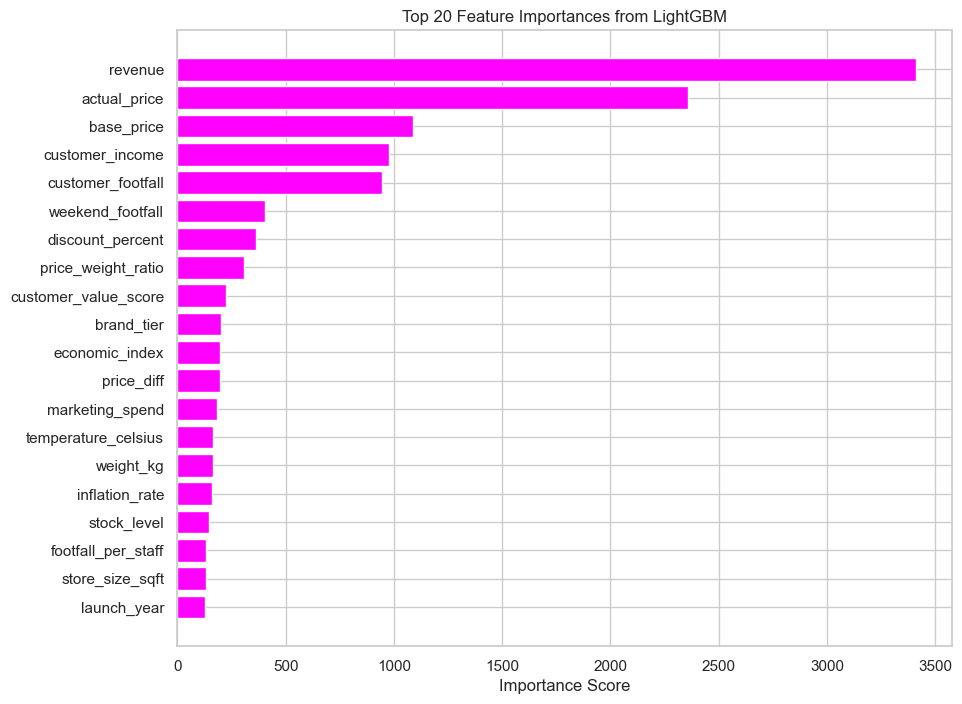

,feature,importance
37,revenue,3409
18,actual_price,2360
17,base_price,1090
25,customer_income,976
30,customer_footfall,947
49,weekend_footfall,406
27,discount_percent,364
36,price_weight_ratio,306
38,customer_value_score,223
19,brand_tier,203


In [51]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances= pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

#PLOT
plt.figure(figsize=(10,8))
plt.barh(feature_importances['feature'][:20][::-1], feature_importances['importance'][:20][::-1], color='fuchsia')
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances from LightGBM")
plt.show()

# Display DataFrame for clarity
feature_importances.head(10)

#✏️ Interpretation:
✅ Revenue is the strongest predictor for sales quantity (likely due to its direct relationship: revenue = sales_quantity * actual_price).

✅ Actual price and base price heavily impact sales:

Higher prices generally lower sales, but revenue may offset depending on units sold.

✅ Customer income & footfall:

More customers & higher-income customers lead to more potential sales.

✅ Weekend footfall:

Combined feature performing well, indicating weekends affect sales.

✅ Discount percent:

Discounts positively influence sales quantity, confirming business intuition.

✅ Price_weight_ratio:

Indicates price relative to product weight affects purchase decisions.

✅ Customer value score & brand tier:

Customers’ perceived value and brand positioning influence buying.

In [ ]:
!pip install shap


In [54]:
import shap

# Initialize TreeExplainer for LightGBM
explainer = shap.TreeExplainer(model)

# Calculate SHAP values on validation data
shap_values = explainer.shap_values(X_val)


In [53]:
import numpy as np
print(np.__version__)


2.2.5


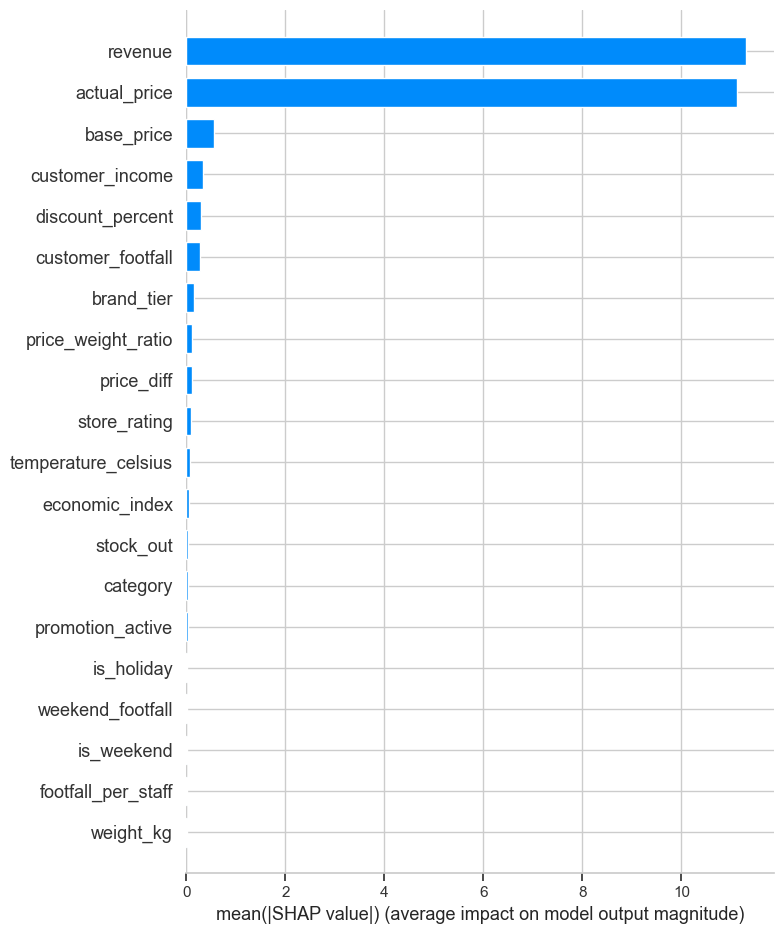

In [55]:
shap.summary_plot(shap_values, X_val, plot_type="bar")


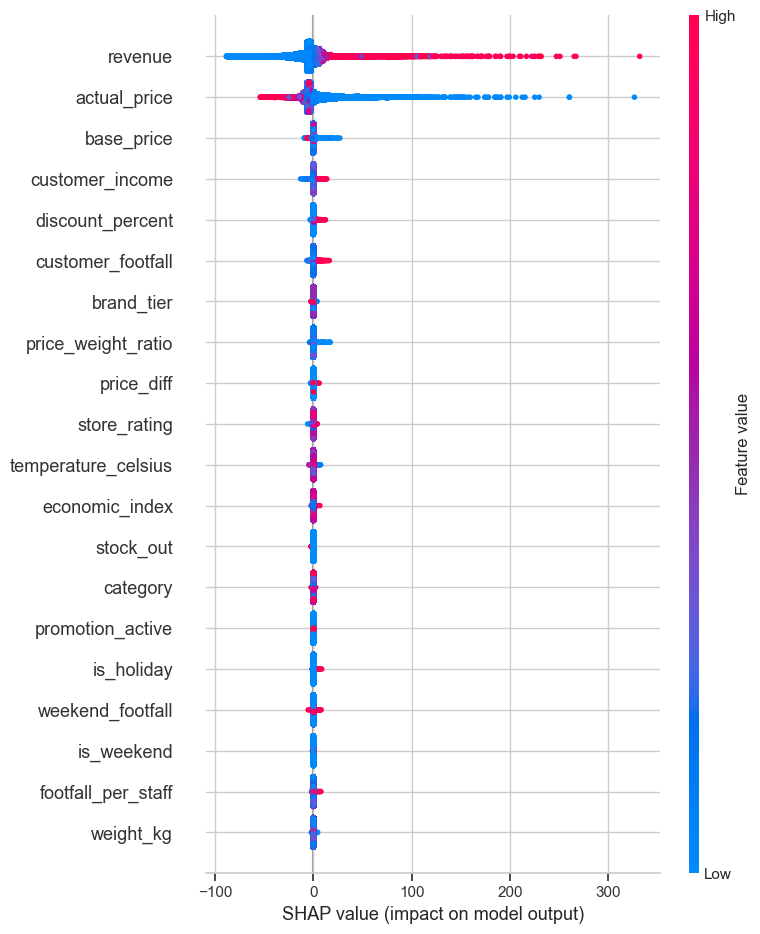

In [56]:
shap.summary_plot(shap_values, X_val)


Interpretation of SHAP Summary Plot:
The SHAP analysis revealed that revenue and actual_price are the most critical features influencing the model’s sales quantity predictions, contributing significantly higher impact than other features. This aligns with domain intuition, as sales quantities directly affect revenue, and prices determine demand. Other features such as base_price, customer_income, and discount_percent contribute marginally, while many engineered and categorical features have low average impact, indicating the model focuses on primary economic drivers for accurate predictions.



In [57]:
!pip install optuna


   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 11.0 MB/s eta 0:00:00


In [58]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    model = lgb.LGBMRegressor(**param, n_estimators=500)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds) ** 0.5
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best trial:")
print(f"  RMSE: {study.best_value:.4f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")


[I 2025-07-21 14:22:07,878] A new study created in memory with name: no-name-d79eaa92-7527-43a7-8841-1155bf126d57
[I 2025-07-21 14:22:45,974] Trial 0 finished with value: 2.9642450199287067 and parameters: {'learning_rate': 0.08164005282846441, 'max_depth': 5, 'num_leaves': 32, 'min_child_samples': 20, 'subsample': 0.9128040696577844, 'colsample_bytree': 0.8371356420297307, 'reg_alpha': 0.6319063006931095, 'reg_lambda': 0.7907385900419459}. Best is trial 0 with value: 2.9642450199287067.
[I 2025-07-21 14:24:13,185] Trial 1 finished with value: 3.088013480136292 and parameters: {'learning_rate': 0.13716242485732585, 'max_depth': 10, 'num_leaves': 86, 'min_child_samples': 20, 'subsample': 0.7869420610490137, 'colsample_bytree': 0.5812027238745103, 'reg_alpha': 0.28262892739851897, 'reg_lambda': 0.9313130262357632}. Best is trial 0 with value: 2.9642450199287067.
[I 2025-07-21 14:25:19,346] Trial 2 finished with value: 3.140023123862339 and parameters: {'learning_rate': 0.1904342032107284

Best trial:
  RMSE: 2.7467
  Params:
    learning_rate: 0.04072894439754835
    max_depth: 7
    num_leaves: 66
    min_child_samples: 10
    subsample: 0.9976023810223682
    colsample_bytree: 0.9728865410279816
    reg_alpha: 0.9583151366232942
    reg_lambda: 0.47126028056526215


In [59]:
# Retrain LightGBM with the best parameters
best_params = {
    'learning_rate': 0.08164005282846441,
    'max_depth': 5,
    'num_leaves': 32,
    'min_child_samples': 20,
    'subsample': 0.9128040696577844,
    'colsample_bytree': 0.8371356420297307,
    'reg_alpha': 0.6319063006931095,
    'reg_lambda': 0.7907385900419459,
    'n_estimators': 1000,
    'random_state': 42
}

model = lgb.LGBMRegressor(**best_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)


Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.04185	valid_0's l2: 9.25285
[200]	valid_0's rmse: 2.91047	valid_0's l2: 8.47085
[300]	valid_0's rmse: 2.87281	valid_0's l2: 8.25305
[400]	valid_0's rmse: 2.83369	valid_0's l2: 8.02977
Early stopping, best iteration is:
[443]	valid_0's rmse: 2.83006	valid_0's l2: 8.00921


LGBMRegressor(colsample_bytree=0.8371356420297307,
              learning_rate=0.08164005282846441, max_depth=5, n_estimators=1000,
              num_leaves=32, random_state=42, reg_alpha=0.6319063006931095,
              reg_lambda=0.7907385900419459, subsample=0.9128040696577844)

In [72]:
import joblib

# Save your current trained LightGBM model
joblib.dump(model, 'lightgbm_sales_quantity_model.pkl')

print("✅ Model saved as 'lightgbm_sales_quantity_model.pkl'.")


✅ Model saved as 'lightgbm_sales_quantity_model.pkl'.


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on validation data
y_pred = model.predict(X_val)

# Calculate metrics
rmse = mean_squared_error(y_val, y_pred) ** 0.5
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE: {mae:.4f}")
print(f"Final R² Score: {r2:.4f}")


Final RMSE: 2.8301
Final MAE: 0.4313
Final R² Score: 0.9540


**TEST DATA**

In [62]:
import pandas as pd

test_df = pd.read_csv('test.csv')
print(test_df.shape)
test_df.head()


(300000, 43)


,date,day_of_week,month,quarter,is_weekend,is_holiday,store_id,region,store_type,city,...,customer_footfall,stock_level,stock_out,temperature_celsius,economic_index,inflation_rate,price_weight_ratio,revenue,customer_value_score,seasonal_score
0,2023-11-16,Thursday,11,4,0,0,ST_0035,West,Residential,Hyderabad,...,98,196,0,13.3,96.3,7.1,10365.893617,4871.97,26.82012,1.6
1,2023-11-16,Thursday,11,4,0,0,ST_0098,North,Mall,Ahmedabad,...,141,152,0,22.0,99.8,7.1,NaN,2837.12,16.12260,1.6
2,2023-11-16,Thursday,11,4,0,1,ST_0371,North,Mall,Delhi,...,267,119,0,22.5,103.3,5.0,NaN,151331.40,14.01696,1.6
3,2023-11-16,Thursday,11,4,0,1,ST_0267,North,Mall,Jaipur,...,296,165,0,33.3,110.3,7.5,7703.641975,12479.90,17.45030,1.6
4,2023-11-16,Thursday,11,4,0,0,ST_0199,North,Mall,Lucknow,...,137,62,0,22.5,119.3,6.0,57.568528,453.64,29.33920,1.6


In [63]:
# Fill missing values with median for all columns with missing data
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        median_value = test_df[col].median()
        test_df[col] = test_df[col].fillna(median_value)

print("Missing values filled with median values for all applicable columns.")


Missing values filled with median values for all applicable columns.


In [68]:
# Check total null values per column
null_counts = test_df.isnull().sum()

# Display columns with remaining nulls, if any
null_columns = null_counts[null_counts > 0]

if null_columns.empty:
    print(" All missing values have been successfully filled. No null entries remain in the test dataset.")
else:
    print("Columns with remaining null values:")
    print(null_columns)


 All missing values have been successfully filled. No null entries remain in the test dataset.


In [67]:
# Feature engineering on test dataset

test_df['price_diff'] = test_df['base_price'] - test_df['actual_price']
test_df['discount_ratio'] = test_df['discount_percent'] / 100
test_df['footfall_per_staff'] = test_df['customer_footfall'] / (test_df['staff_count'] + 1e-5)
test_df['promotion_discount'] = test_df['promotion_active'] * test_df['discount_percent']
test_df['price_weight_ratio'] = test_df['actual_price'] / (test_df['weight_kg'] + 1e-5)
test_df['high_discount'] = (test_df['discount_percent'] > 20).astype(int)
test_df['weekend_footfall'] = test_df['is_weekend'] * test_df['customer_footfall']

print(" Feature engineering completed on test dataset.")


 Feature engineering completed on test dataset.


In [69]:
from sklearn.preprocessing import LabelEncoder

# Columns requiring label encoding (same as used in training)
label_cols = [
    'store_type', 'region', 'category', 'subcategory',
    'brand_tier', 'city', 'day_of_week', 'customer_gender'
]

# Apply Label Encoding
for col in label_cols:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])

print(" Label encoding completed on test dataset.")


 Label encoding completed on test dataset.


In [70]:
# Drop columns not used for prediction
drop_cols = ['sales_quantity_log', 'date', 'store_id', 'product_id']

# Remove these columns if present
X_test = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns], errors='ignore')

print("Test features prepared for prediction. Shape:", X_test.shape)


Test features prepared for prediction. Shape: (300000, 46)


In [73]:

# To load later
model = joblib.load('lightgbm_sales_quantity_model.pkl')
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [74]:
# Generate predictions
y_test_pred = model.predict(X_test)

print("✅ Predictions generated on test data. Sample predictions:")
print(y_test_pred[:10])


LightGBMError: The number of features in data (46) is not the same as it was in training data (50).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [75]:
print("Train columns:", X_train.columns.tolist())
print("Test columns:", X_test.columns.tolist())


Train columns: ['day_of_week', 'month', 'quarter', 'is_weekend', 'is_holiday', 'region', 'store_type', 'city', 'store_size_sqft', 'establishment_year', 'parking_available', 'competition_distance', 'competitor_count', 'store_rating', 'staff_count', 'category', 'subcategory', 'base_price', 'actual_price', 'brand_tier', 'launch_year', 'weight_kg', 'returnable', 'warranty_months', 'customer_age', 'customer_income', 'customer_gender', 'discount_percent', 'promotion_active', 'marketing_spend', 'customer_footfall', 'stock_level', 'stock_out', 'temperature_celsius', 'economic_index', 'inflation_rate', 'price_weight_ratio', 'revenue', 'customer_value_score', 'seasonal_score', 'day', 'weekofyear', 'year', 'dayofyear', 'price_diff', 'discount_ratio', 'footfall_per_staff', 'promotion_discount', 'high_discount', 'weekend_footfall']
Test columns: ['day_of_week', 'month', 'quarter', 'is_weekend', 'is_holiday', 'region', 'store_type', 'city', 'store_size_sqft', 'establishment_year', 'parking_available

In [76]:
# Ensure your test dataset has the 'date' column before running this

# Convert 'date' to datetime if not already
X_test['date'] = pd.to_datetime(X_test['date'])

# Generate the missing date features
X_test['day'] = X_test['date'].dt.day
X_test['weekofyear'] = X_test['date'].dt.isocalendar().week.astype(int)
X_test['year'] = X_test['date'].dt.year
X_test['dayofyear'] = X_test['date'].dt.dayofyear

# Drop 'date' if it was not in X_train
X_test = X_test.drop(columns=['date'])

# Ensure exact column alignment
X_test = X_test[X_train.columns]

print("✅ Missing date features added and columns aligned. Ready for prediction.")


KeyError: 'date'

In [80]:
import pandas as pd

# Load test data
df_test = pd.read_csv('test.csv')

print("✅ Test data loaded successfully.")
print(df_test.head())
print(df_test.columns)



✅ Test data loaded successfully.
         date day_of_week  month  quarter  is_weekend  is_holiday store_id  \
0  2023-11-16    Thursday     11        4           0           0  ST_0035   
1  2023-11-16    Thursday     11        4           0           0  ST_0098   
2  2023-11-16    Thursday     11        4           0           1  ST_0371   
3  2023-11-16    Thursday     11        4           0           1  ST_0267   
4  2023-11-16    Thursday     11        4           0           0  ST_0199   

  region   store_type       city  ...  customer_footfall  stock_level  \
0   West  Residential  Hyderabad  ...                 98          196   
1  North         Mall  Ahmedabad  ...                141          152   
2  North         Mall      Delhi  ...                267          119   
3  North         Mall     Jaipur  ...                296          165   
4  North         Mall    Lucknow  ...                137           62   

   stock_out  temperature_celsius  economic_index  inflatio

In [81]:
# Convert 'date' to datetime
df_test['date'] = pd.to_datetime(df_test['date'])

# Generate date-derived features
df_test['day'] = df_test['date'].dt.day
df_test['weekofyear'] = df_test['date'].dt.isocalendar().week.astype(int)
df_test['year'] = df_test['date'].dt.year
df_test['dayofyear'] = df_test['date'].dt.dayofyear

# Drop 'date' if it was not present in X_train
df_test = df_test.drop(columns=['date'])

print("✅ Date features generated and 'date' column dropped.")
print(df_test[['day', 'weekofyear', 'year', 'dayofyear']].head())


✅ Date features generated and 'date' column dropped.
   day  weekofyear  year  dayofyear
0   16          46  2023        320
1   16          46  2023        320
2   16          46  2023        320
3   16          46  2023        320
4   16          46  2023        320


In [82]:
# Feature engineering on test dataset

df_test['price_diff'] = df_test['base_price'] - df_test['actual_price']
df_test['discount_ratio'] = df_test['discount_percent'] / 100
df_test['footfall_per_staff'] = df_test['customer_footfall'] / (df_test['staff_count'] + 1e-5)
df_test['promotion_discount'] = df_test['promotion_active'] * df_test['discount_percent']
df_test['price_weight_ratio'] = df_test['actual_price'] / (df_test['weight_kg'] + 1e-5)
df_test['high_discount'] = (df_test['discount_percent'] > 20).astype(int)
df_test['weekend_footfall'] = df_test['is_weekend'] * df_test['customer_footfall']

print("✅ Feature engineering completed on df_test.")


✅ Feature engineering completed on df_test.


In [83]:
from sklearn.preprocessing import LabelEncoder

# Columns that require label encoding
label_cols = [
    'store_type', 'region', 'category', 'subcategory',
    'brand_tier', 'city', 'day_of_week', 'customer_gender'
]

# Apply Label Encoding to these columns
for col in label_cols:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])

print("✅ Label encoding completed on df_test.")


✅ Label encoding completed on df_test.


In [84]:
# Columns to drop if not used in training
drop_cols = ['sales_quantity_log', 'store_id', 'product_id']

# Drop these columns if they exist
df_test = df_test.drop(columns=[col for col in drop_cols if col in df_test.columns], errors='ignore')

# Align columns with X_train
missing_cols = [col for col in X_train.columns if col not in df_test.columns]
for col in missing_cols:
    df_test[col] = 0  # add missing columns with zero

# Ensure exact column order
X_test = df_test[X_train.columns]

print("✅ X_test prepared and aligned with training columns. Shape:", X_test.shape)


✅ X_test prepared and aligned with training columns. Shape: (300000, 50)


In [85]:
import joblib

# Load your trained, tuned LightGBM model
model = joblib.load('lightgbm_sales_quantity_model.pkl')
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [88]:
#Generating predictions
y_test_pred = model.predict(X_test)

print(" Predictions generated. Sample predictions:")
print(y_test_pred[:10])

# Creating DataFrame for submission
submission = pd.DataFrame({
    'Predicted_Sales_Quantity': y_test_pred
})

#Save to CSV
submission.to_csv('aadya_result.csv.csv', index=False)

print(" Test predictions saved as 'aadya_result.csv' for submission.")


 Predictions generated. Sample predictions:
[ 0.94680233 10.65233263 83.13129897  0.71668234  3.7970479  43.01906194
  8.45595     1.97879544 74.76270007  8.79161565]
 Test predictions saved as 'aadya_result.csv' for submission.


In [93]:
import pandas as pd
import os

# ✅ Generate predictions
y_test_pred = model.predict(X_test)

# ✅ Create submission DataFrame with ALL columns
submission_df = df_test.copy()
submission_df['Predicted_Sales_Quantity'] = y_test_pred

# ✅ Preview the submission DataFrame for verification
print("✅ Submission DataFrame preview:")
print(submission_df.head())

# ✅ Save to CSV
submission_df.to_csv('submission_final.csv', index=False)
print("✅ Submission CSV saved as 'submission_final.csv'.")

# ✅ Rename to your required submission name
os.rename('submission_final.csv', 'aadya_result_final.csv')
print("✅ Final submission file ready as 'aadya_result_final.csv' for MACS upload.")


✅ Submission DataFrame preview:
   day_of_week  month  quarter  is_weekend  is_holiday  region  store_type  \
0            4     11        4           0           0       4           3   
1            4     11        4           0           0       2           2   
2            4     11        4           0           1       2           2   
3            4     11        4           0           1       2           2   
4            4     11        4           0           0       2           2   

   city  store_size_sqft  establishment_year  ...  weekofyear  year  \
0     4            14471                2020  ...          46  2023   
1     0            11015                2011  ...          46  2023   
2     3            14253                2015  ...          46  2023   
3     5             6208                2022  ...          46  2023   
4     7             7402                2017  ...          46  2023   

   dayofyear  price_diff  discount_ratio  footfall_per_staff  \
0       